Awesome — this sounds like a great move toward organizing your experimentation work into polished, reusable insights. Let's start crafting that **topic modeling-focused notebook**. Here’s a proposed outline for the cleaned-up notebook structure, with markdown and code blocks arranged clearly:

---

## 🧠 Notebook Title: *Evaluating Topic Modeling for Risk Score Prediction in Financial News*

### 🔍 Notebook Objective (markdown)
> This notebook explores whether topic modeling via BERTopic can be a valuable feature engineering step in predicting stock price movements. Specifically, we aim to test the hypothesis that topic-driven features can replace or enhance token-based risk scores used previously.

---

### 1. Load Required Libraries

```

---

### 2. Connect to DuckDB and Load Dataset
```python
# %% Connect to DuckDB and Load Dataset
db_path = '/Users/bradams/Documents/financial_news.db'
conn = duckdb.connect(database=db_path, read_only=False)

query = """ 
-- same query used earlier, selecting title, description, price_change_percentage, and sentiment columns
"""

news_data = conn.execute(query).fetchdf()
conn.close()
news_data.info()
```

---

### 3. Apply BERTopic to Extract Topics
```python
# %% Generate BERTopic Topics
texts = news_data["article_title"].fillna("") + " " + news_data["description"].fillna("")
embedding_model = SentenceTransformer("paraphrase-MiniLM-L3-v2")
bertopic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=UMAP(n_neighbors=5, min_dist=0.5, n_components=5, metric='cosine'),
    verbose=True
)
topics, probs = bertopic_model.fit_transform(texts.tolist())
news_data["topic"] = topics
news_data["topic_probability"] = [max(p) if isinstance(p, list) else 0 for p in probs]
```

---

### 🧠 Section: Topic Modeling Intuition (markdown)
> BERTopic groups similar articles into semantically coherent topics using UMAP and HDBSCAN over sentence embeddings. Each article is assigned a topic and a probability of belonging to that topic. These topic features may reflect market-relevant themes that impact price changes.

---

### 4. Engineer Topic-Based Features
```python
# %% Topic Features
news_data["topic_avg_movement"] = news_data.groupby("topic")["price_change_percentage"].transform("mean")
news_data["topic_sensitivity"] = news_data.groupby("topic")["price_change_percentage"].transform("std")
```

---

### 5. Create Risk Score from Topic and Sentiment
```python
# %% Create Sentiment-Weighted Risk Score
news_data["sentiment_impact"] = news_data["finbert_description_positive"] - news_data["finbert_description_negative"]
news_data["market_volatility"] = news_data.groupby("ticker")["price_change_percentage"].transform(lambda x: x.rolling(window=30, min_periods=1).std())
news_data["risk_score_topic"] = (
    news_data["sentiment_impact"] * news_data["topic_sensitivity"]
) * news_data["market_volatility"]
```

---

### 6. Train Regression Model with Topic Features
```python
# %% Train Model Using Topic-Based Features
features = [
    "topic_avg_movement", "topic_sensitivity", "sentiment_impact", "market_volatility",
    "finbert_title_positive", "finbert_title_negative", "finbert_description_positive", "finbert_description_negative"
]
X = news_data[features].replace([np.inf, -np.inf], np.nan).dropna()
y = news_data.loc[X.index, "price_change_percentage"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}, R²: {r2_score(y_test, y_pred):.4f}")
```

---

### 📊 Section: Preliminary Evaluation (markdown)
> The model’s performance using topic-based features is compared to prior models that used token-level risk scores. We’ll evaluate based on MAE and R² metrics. If topic features yield competitive performance, they may offer a scalable alternative to token-based approaches.

---

### 7. Visualize Topic Sensitivities and Volatilities
```python
# %% Plot Topic Sensitivity vs Average Price Movement
plt.figure(figsize=(10, 6))
sns.scatterplot(data=news_data, x="topic_avg_movement", y="topic_sensitivity", hue="topic", palette="tab10", alpha=0.6)
plt.title("Topic Sensitivity vs Average Movement")
plt.xlabel("Average Price Movement")
plt.ylabel("Standard Deviation (Sensitivity)")
plt.show()
```

---

### 📌 Final Notes (markdown)
> - Replace token_score with topic-driven features for risk scoring? Promising.
> - Tradeoff: Topic modeling requires more compute but produces interpretable clusters.
> - Next step: compare this to token-focused risk and see which yields more stable predictive performance across tickers.

---

Would you like me to generate this clean notebook file for you now (either here or directly in `.ipynb` format), or are you planning to copy/paste and run section-by-section first before I finalize it?

In [7]:
# %% Load Libraries
import pandas as pd
import numpy as np
import duckdb
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [18]:
# %% Connect to DuckDB and Load Dataset
db_path = r'C:\Users\btada\Documents\financial_news.db'
conn = duckdb.connect(database=db_path, read_only=False)

# %% Get All Available Tickers & Sample a Subset
query_tickers = "SELECT DISTINCT ticker FROM Headlines.Articles_Trading_Day"
ticker_df = conn.execute(query_tickers).fetchdf()

# Randomly sample 20 tickers for testing
ticker_all = random.sample(list(ticker_df["ticker"]), 50)

# Build a query to only include your sampled tickers
placeholders = ",".join(["?"] * len(ticker_all))

query = f"""
SELECT 
    a.ticker,
    a.article_title,
    a.mapped_trading_date AS publish_date,
    a.description, 
    dpm.price_change_percentage,
    f.finbert_title_score,
    f.finbert_description_score,
    f.finbert_title_positive,
    f.finbert_title_neutral,
    f.finbert_title_negative,
    f.finbert_description_positive,
    f.finbert_description_neutral,
    f.finbert_description_negative
FROM "Headlines"."Articles_Trading_Day" a
INNER JOIN "Headlines"."Daily_Price_Movement" dpm
    ON a.mapped_trading_date = dpm.trading_date 
    AND a.ticker = dpm.ticker
INNER JOIN "Headlines"."finbert_analysis" f
    ON a.guid = f.guid
WHERE a.ticker IN ({placeholders})
"""
# Execute with parameters
news_data = conn.execute(query, ticker_all).fetchdf()

#conn.close()
news_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27754 entries, 0 to 27753
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   ticker                        27754 non-null  object        
 1   article_title                 27754 non-null  object        
 2   publish_date                  27754 non-null  datetime64[us]
 3   description                   27754 non-null  object        
 4   price_change_percentage       27689 non-null  float32       
 5   finbert_title_score           27754 non-null  float32       
 6   finbert_description_score     27754 non-null  float32       
 7   finbert_title_positive        27754 non-null  float32       
 8   finbert_title_neutral         27754 non-null  float32       
 9   finbert_title_negative        27754 non-null  float32       
 10  finbert_description_positive  27754 non-null  float32       
 11  finbert_description_neutral 

In [11]:
# %% Generate BERTopic Topics
texts = news_data["article_title"].fillna("") + " " + news_data["description"].fillna("")
embedding_model = SentenceTransformer("paraphrase-MiniLM-L3-v2")
bertopic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=UMAP(n_neighbors=5, min_dist=0.5, n_components=5, metric='cosine'),
    verbose=True
)
topics, probs = bertopic_model.fit_transform(texts.tolist())
news_data["topic"] = topics
news_data["topic_probability"] = [max(p) if isinstance(p, list) else 0 for p in probs]

2025-04-02 17:49:36,280 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/1083 [00:00<?, ?it/s]

2025-04-02 17:49:53,194 - BERTopic - Embedding - Completed ✓
2025-04-02 17:49:53,194 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-02 17:50:22,885 - BERTopic - Dimensionality - Completed ✓
2025-04-02 17:50:22,885 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-02 17:50:26,287 - BERTopic - Cluster - Completed ✓
2025-04-02 17:50:26,307 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-04-02 17:50:27,906 - BERTopic - Representation - Completed ✓


In [12]:
# %% Topic Features
news_data["topic_avg_movement"] = news_data.groupby("topic")["price_change_percentage"].transform("mean")
news_data["topic_sensitivity"] = news_data.groupby("topic")["price_change_percentage"].transform("std")

In [13]:
# %% Create Sentiment-Weighted Risk Score
news_data["sentiment_impact"] = news_data["finbert_description_positive"] - news_data["finbert_description_negative"]
news_data["market_volatility"] = news_data.groupby("ticker")["price_change_percentage"].transform(lambda x: x.rolling(window=30, min_periods=1).std())
news_data["risk_score_topic"] = (
    news_data["sentiment_impact"] * news_data["topic_sensitivity"]
) * news_data["market_volatility"]

In [15]:
features = [
    "topic_avg_movement", "topic_sensitivity", "sentiment_impact", "market_volatility",
    "finbert_title_positive", "finbert_title_negative", "finbert_description_positive", "finbert_description_negative"
]
X = news_data[features].replace([np.inf, -np.inf], np.nan).dropna()
y = news_data.loc[X.index, "price_change_percentage"]

# Replace inf/-inf with NaN
y = y.replace([np.inf, -np.inf], np.nan)

# Drop corresponding rows in X and y where y is NaN
mask = y.notna()
X = X[mask]
y = y[mask]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}, R²: {r2_score(y_test, y_pred):.4f}")

MAE: 0.8814, R²: 0.1828


In [25]:
def process_ticker_topic_modeling(ticker, conn):
    query = f"""
    SELECT 
        a.ticker,
        a.mapped_trading_date AS publish_date,
        a.article_title,
        a.description, 
        dpm.price_change_percentage,
        f.finbert_title_score,
        f.finbert_description_score,
        f.finbert_title_positive,
        f.finbert_title_neutral,
        f.finbert_title_negative,
        f.finbert_description_positive,
        f.finbert_description_neutral,
        f.finbert_description_negative
    FROM "Headlines"."Articles_Trading_Day" a
    INNER JOIN "Headlines"."Daily_Price_Movement" dpm
        ON a.mapped_trading_date = dpm.trading_date 
        AND a.ticker = dpm.ticker
    INNER JOIN "Headlines"."finbert_analysis" f
        ON a.guid = f.guid
    WHERE a.ticker = ?
    """
    
    news_df = conn.execute(query, [ticker]).fetchdf()
    if news_df.empty:
        return None
    
    # Combine text for BERTopic
    texts = news_df["article_title"].fillna("") + " " + news_df["description"].fillna("")
    embedding_model = SentenceTransformer("paraphrase-MiniLM-L3-v2")
    topic_model = BERTopic(
        embedding_model=embedding_model,
        umap_model=UMAP(n_neighbors=5, min_dist=0.5, n_components=5),
        verbose=False
    )
    topics, probs = topic_model.fit_transform(texts.tolist())
    news_df["topic"] = topics
    news_df["topic_probability"] = [max(p) if isinstance(p, list) else 0 for p in probs]
    
    # Features
    news_df["topic_avg_movement"] = news_df.groupby("topic")["price_change_percentage"].transform("mean")
    news_df["topic_sensitivity"] = news_df.groupby("topic")["price_change_percentage"].transform("std")
    news_df["sentiment_impact"] = news_df["finbert_description_positive"] - news_df["finbert_description_negative"]
    news_df["market_volatility"] = news_df["price_change_percentage"].rolling(window=30, min_periods=1).std()
    news_df["risk_score_topic"] = (
        news_df["sentiment_impact"] * news_df["topic_sensitivity"]
    ) * news_df["market_volatility"]

    # Prepare data
    features = [
        "risk_score_topic", "topic_avg_movement", "topic_sensitivity", "sentiment_impact", "market_volatility",
        "finbert_title_positive", "finbert_title_negative", "finbert_description_positive", "finbert_description_negative"
    ]
    df = news_df[features + ["price_change_percentage"]].replace([np.inf, -np.inf], np.nan).dropna()
    
    if df.shape[0] < 10:
        return None  # skip small datasets

    # Compute correlation of each feature with the target
    corr_dict = df.corr(numeric_only=True)["price_change_percentage"].drop("price_change_percentage").to_dict()

    # Train/test split and model training
    X = df[features]
    y = df["price_change_percentage"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    model = XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Assemble result
    result = {
        "ticker": ticker,
        "mae": mean_absolute_error(y_test, y_pred),
        "r2": r2_score(y_test, y_pred),
        "n_articles" : len(news_df)
    }

    # Add correlation values to result
    for feature_name, corr_value in corr_dict.items():
        result[f"corr_{feature_name}"] = corr_value

    return result


In [26]:
results = []
for ticker in ticker_all:
    print(f"Processing {ticker}...")
    result = process_ticker_topic_modeling(ticker, conn)
    if result:
        results.append(result)

results_df = pd.DataFrame(results)
print(results_df.sort_values("r2", ascending=False).head(10))

Processing THO...
Processing HAS...
Processing PNFP...
Processing NUE...
Processing CBRE...
Processing MSI...
Processing RACE...
Processing FIVE...
Processing SMCI...
Processing BKNG...
Processing NTAP...
Processing ELAN...
Processing PB...
Processing GWRE...
Processing FIX...
Processing CCL...
Processing INTU...
Processing PFGC...
Processing SYF...
Processing DFH...
Processing NSP...
Processing TSLA...
Processing NFE...
Processing APLS...
Processing APPF...
Processing ITCI...
Processing WAY...
Processing ICLR...
Processing BE...
Processing PSTG...
Processing RTX...
Processing BCPC...
Processing VCTR...
Processing KEX...
Processing CE...
Processing GPI...
Processing MUR...
Processing Z...
Processing ARMK...
Processing TRU...
Processing SFM...
Processing AN...
Processing MDU...
Processing TPG...
Processing BEN...
Processing CCCS...
Processing RPM...
Processing CRH...
Processing COTY...
Processing EQIX...
   ticker       mae        r2  n_articles  corr_risk_score_topic  \
37      Z  0.81

In [28]:
from tabulate import tabulate

print(tabulate(results_df, headers='keys', tablefmt="psql"))

+----+----------+----------+-------------+--------------+-------------------------+---------------------------+--------------------------+-------------------------+--------------------------+-------------------------------+-------------------------------+-------------------------------------+-------------------------------------+
|    | ticker   |      mae |          r2 |   n_articles |   corr_risk_score_topic |   corr_topic_avg_movement |   corr_topic_sensitivity |   corr_sentiment_impact |   corr_market_volatility |   corr_finbert_title_positive |   corr_finbert_title_negative |   corr_finbert_description_positive |   corr_finbert_description_negative |
|----+----------+----------+-------------+--------------+-------------------------+---------------------------+--------------------------+-------------------------+--------------------------+-------------------------------+-------------------------------+-------------------------------------+-------------------------------------|
|  0

In [29]:
# Remove NAs (if any) for correlation columns
corr_cols = [col for col in results_df.columns if col.startswith("corr_")]
abs_corr_summary = results_df[corr_cols].abs().median().sort_values(ascending=False)
print(abs_corr_summary)


corr_topic_avg_movement              0.148984
corr_market_volatility               0.097140
corr_risk_score_topic                0.077078
corr_topic_sensitivity               0.070787
corr_finbert_description_negative    0.066648
corr_finbert_title_negative          0.059918
corr_sentiment_impact                0.058866
corr_finbert_title_positive          0.046521
corr_finbert_description_positive    0.043972
dtype: float64


In [30]:
import pandas as pd

low_sample = results_df[results_df["n_articles"] < 100]
print(f"Tickers with < 100 articles: {len(low_sample)}")
display(low_sample[["ticker", "n_articles", "r2"]])


Tickers with < 100 articles: 8


,ticker,n_articles,r2
2,PNFP,76,-0.059404
19,DFH,40,-0.511461
20,NSP,49,-0.384097
26,WAY,25,-0.289649
28,BE,46,-1.676230
31,BCPC,57,-0.665741
43,TPG,88,-1.034592
45,CCCS,53,-0.341528


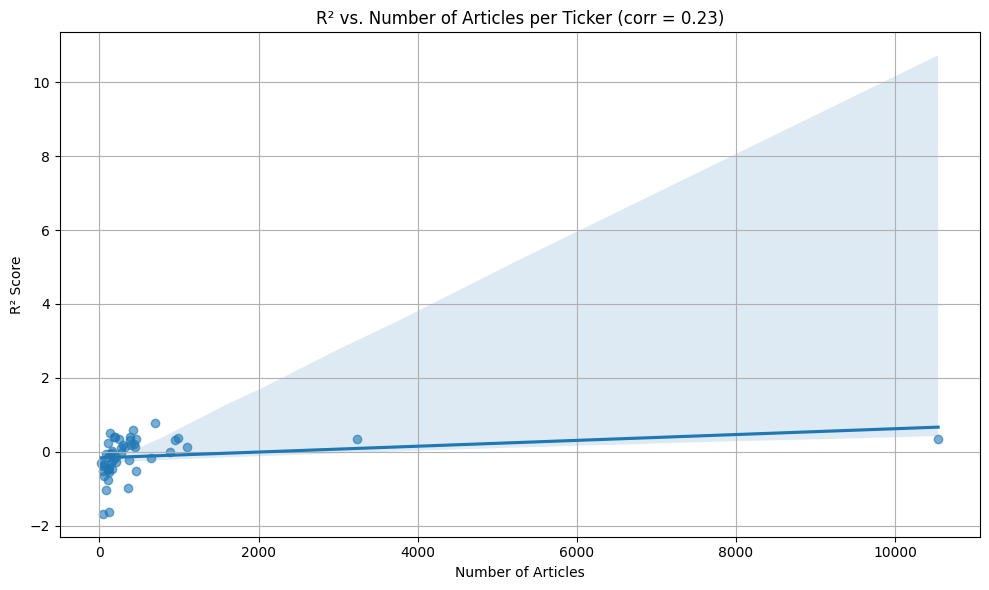

np.float64(0.2338869408794584)

In [31]:
# Check correlation between n_articles and r2
correlation = results_df[["n_articles", "r2"]].corr().iloc[0, 1]

# Create plot: n_articles vs r2
plt.figure(figsize=(10, 6))
sns.regplot(data=results_df, x="n_articles", y="r2", scatter_kws={"alpha":0.6})
plt.title(f"R² vs. Number of Articles per Ticker (corr = {correlation:.2f})")
plt.xlabel("Number of Articles")
plt.ylabel("R² Score")
plt.grid(True)
plt.tight_layout()
plt.show()

correlation

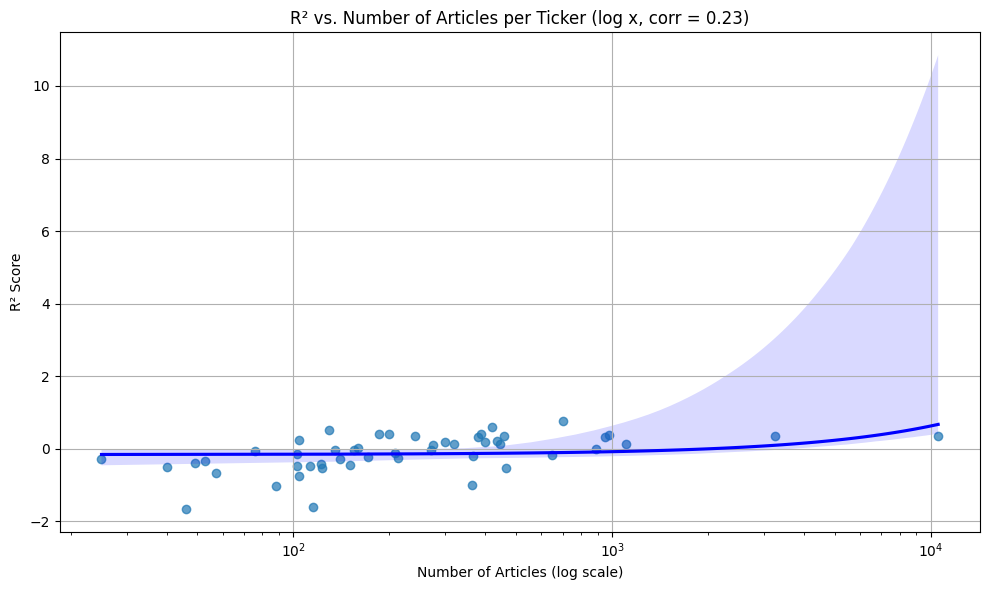

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Compute Pearson correlation
correlation = results_df[["n_articles", "r2"]].corr().iloc[0, 1]

# Plotting with log scale on x-axis to handle skew
plt.figure(figsize=(10, 6))
sns.regplot(data=results_df, x="n_articles", y="r2", scatter_kws={"alpha":0.7}, line_kws={"color": "blue"})
plt.xscale("log")
plt.title(f"R² vs. Number of Articles per Ticker (log x, corr = {correlation:.2f})")
plt.xlabel("Number of Articles (log scale)")
plt.ylabel("R² Score")
plt.grid(True)
plt.tight_layout()
plt.show()
